# Testing OACE model



In [1]:
#imports
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import MobileNet_V2_Weights
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import mediapipe as mp
import itertools
from matplotlib.patches import Patch
from tqdm import tqdm #for progress bar


In [2]:
#model loading
model_path = 'models/eye_detector_mobilenetv2_(OACE_dataset).pth'

#recreated the same architecture
model = models.mobilenet_v2(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)   # 2 classes: open / closed
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load checkpoint
checkpoint = torch.load(model_path, map_location=device, weights_only=False)


#restore weights
model.load_state_dict(checkpoint['model_state_dict'])

#restore label mapping
idx_to_class = {v: k for k, v in checkpoint['class_to_idx'].items()}

#move model to device and set to eval mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
#image transformer
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

print("Model loaded successfully!")
print("Class labels:", idx_to_class)


Model loaded successfully!
Class labels: {0: 'close', 1: 'open'}


function to make a prediction for a given image,model,transformer,device,idx

In [3]:
def predict_image(img_pil, model, transform, device, idx_to_class):
    model.eval()
    x = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        prob = torch.softmax(out, dim=1)
        pred = prob.argmax(dim=1).item()
        conf = prob.max().item()
    return idx_to_class[pred], conf

## Extracting Eye Region from a Image
MRL-style eye extraction using Mediapipe iris landmarks

In [4]:
IMAGE_FOLDER = "local_images" #local clicked images folder
OUTPUT_DIR = "local_image_eye_crops"
SCALE = 4  #how large the square is relative to iris diameter

os.makedirs(OUTPUT_DIR, exist_ok=True)

#FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=10,
    min_detection_confidence=0.5
)

#Iris landmarks taken from MediaPipe FaceMesh
LEFT_IRIS = [474, 475, 476, 477]
RIGHT_IRIS = [469, 470, 471, 472]

#case handle if there are multiple faces in an image
total_eye_counter = 0
img_id = 0

for img_name in os.listdir(IMAGE_FOLDER):
    IMAGE_PATH = os.path.join(IMAGE_FOLDER, img_name)
    img = cv2.imread(IMAGE_PATH)
    
    if img is None:
        print(f"Cannot load image: {IMAGE_PATH}")
        continue
    
    h, w, _ = img.shape #height, width, channels
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if not results.multi_face_landmarks:
        print(f"No faces detected in {img_name}")
        continue

    #process each face detected
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks, start=1):
        landmarks = face_landmarks.landmark

        def get_iris_center_and_radius(iris_indices):
            pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in iris_indices])
            (cx, cy), radius = cv2.minEnclosingCircle(pts)
            return int(cx), int(cy), int(radius)

        #left eye
        lx, ly, lr = get_iris_center_and_radius(LEFT_IRIS)
        left_size = int(lr * SCALE)
        lx1, ly1 = max(lx - left_size, 0), max(ly - left_size, 0)
        lx2, ly2 = min(lx + left_size, w), min(ly + left_size, h)
        left_eye_crop = img[ly1:ly2, lx1:lx2]

        left_eye_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(img_name)[0]}_person{face_id}_left_eye_{img_id}.png")
        cv2.imwrite(left_eye_path, left_eye_crop)

        #right eye
        rx, ry, rr = get_iris_center_and_radius(RIGHT_IRIS)
        right_size = int(rr * SCALE)
        rx1, ry1 = max(rx - right_size, 0), max(ry - right_size, 0)
        rx2, ry2 = min(rx + right_size, w), min(ry + right_size, h)
        right_eye_crop = img[ry1:ry2, rx1:rx2]

        right_eye_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(img_name)[0]}_person{face_id}_right_eye_{img_id}.png")
        cv2.imwrite(right_eye_path, right_eye_crop)

        #visualization
        cv2.circle(img, (lx, ly), 3, (0, 255, 0), -1)
        cv2.circle(img, (rx, ry), 3, (0, 255, 0), -1)
        cv2.rectangle(img, (lx1, ly1), (lx2, ly2), (0, 255, 0), 2)
        cv2.rectangle(img, (rx1, ry1), (rx2, ry2), (0, 255, 0), 2)
        cv2.putText(img, f"P{face_id}", (lx1, ly1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        total_eye_counter += 2
        img_id += 1
print(f"\n Extracted {total_eye_counter} eye crops and saved inside '{OUTPUT_DIR}'.")
cv2.destroyAllWindows()



 Extracted 52 eye crops and saved inside 'local_image_eye_crops'.


In [5]:
def preprocess_eye_image(
    img_path: str,#path to eye image
    output_size=(82, 82),#final output size
    gamma_value=0.6,#gamma correction value
    clip_limit=2.0,#CLAHE clip limit
    tile_size=(6, 6),#tile size for CLAHE
    noise_std=6,#noise standard deviation
    brightness_factor=1.1,#adjust overall brightness
    dark_boost_strength=0.5,#adjust boost for dark regions
    target_mean=83,#global target mean mrl dataset
    target_std=15.5,#global target standard deviation mrl dataset
):
    #loadd image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Cannot load image: {img_path}")

    #grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 5, 30, 30)  #preserves edges
    gray = cv2.equalizeHist(gray)  #global normalization

    #CLAHE for local contrast normalization
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    balanced = clahe.apply(gray)

    #gamma correction (to compress highlights)
    invGamma = 1.0 / gamma_value
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(balanced, table)

    #soft smoothing (to remove harsh local contrast)
    smoothed = cv2.bilateralFilter(gamma_corrected, 3, 40, 40)

    #add subtle Gaussian noise
    noise = np.random.normal(0, noise_std, smoothed.shape)
    noisy = np.clip(smoothed.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    #brighten darker regions selectively
    img_f = noisy.astype(np.float32)
    boost = dark_boost_strength * (1 - img_f / 255.0) * 70
    brightened = np.clip(img_f + boost, 0, 255)

    #global brightness boost
    brightened = np.clip(brightened * brightness_factor, 0, 255).astype(np.uint8)

    #normalize histogram to MRL mean/std
    mean, std = brightened.mean(), brightened.std()
    normalized = np.clip((brightened - mean) / (std + 1e-6) * target_std + target_mean, 0, 255).astype(np.uint8)

    #resize
    final_resized = cv2.resize(normalized, output_size, interpolation=cv2.INTER_AREA)

    return final_resized


In [6]:
#Test on a sample processed image
img_path = "local_image_eye_crops/image_7_person1_right_eye_23.png"#path to an image in OACE Eye Dataset
preprocessed_img = preprocess_eye_image(img_path)
pil = Image.fromarray(preprocessed_img).convert('RGB')
label, conf = predict_image(pil, model, transformer, device, idx_to_class) # prediciton class, confidence

print('Processed Image Prediction:', label, conf)

Processed Image Prediction: close 0.9997925162315369


## Now accuracy for all Local images taken

**We see a significant boost in confidance for local_images datset after preprocessing**

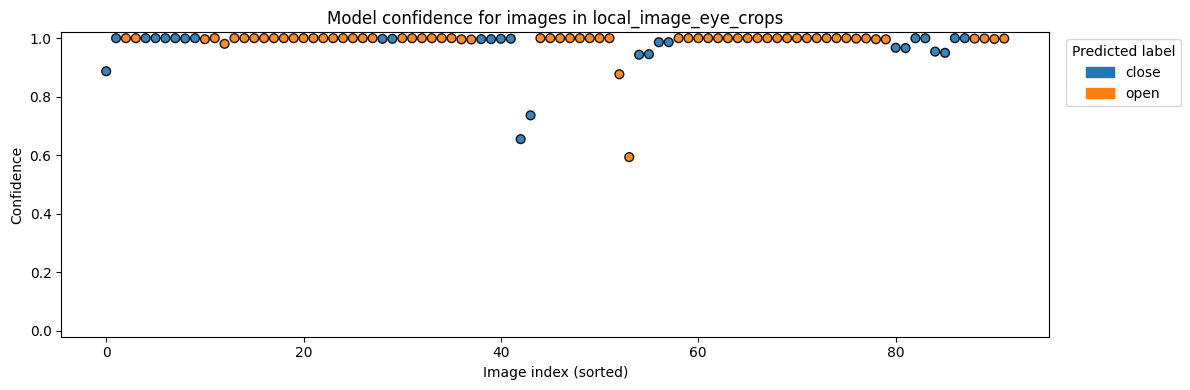

In [8]:
local_dir = OUTPUT_DIR  #use existing variable
exts = {'.png', '.jpg', '.jpeg'}

files = sorted([f for f in os.listdir(local_dir) if os.path.splitext(f)[1].lower() in exts])
local_list = [] 
preds = {}  # initialize predictions dict to avoid NameError

for fname in files:
    path = os.path.join(local_dir, fname)
    try:
        proc_np = preprocess_eye_image(path)  #returns 82x82 grayscale np.uint8
        pil_img = Image.fromarray(proc_np).convert('RGB')
        label, conf = predict_image(pil_img, model, transformer, device, idx_to_class)
        conf = float(conf)
    except Exception as e:
        label = "error"
        conf = 0.0

    preds[fname] = {"label": label, "conf": conf}
    local_list.append((fname, conf))


#scatter plot of confidences, colored by label
labels = [preds[f]["label"] for f, _ in local_list]
confs = [preds[f]["conf"] for f, _ in local_list]
indices = np.arange(len(local_list))

unique_labels = sorted(set(labels))
color_map = {lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)}
colors = [color_map[lab] for lab in labels]

plt.figure(figsize=(12, 4))
plt.scatter(indices, confs, c=colors, s=40, edgecolor='k', alpha=0.9)
plt.ylim(-0.02, 1.02)
plt.xlabel("Image index (sorted)")
plt.ylabel("Confidence")
plt.title("Model confidence for images in local_image_eye_crops")



#legend
legend_handles = [Patch(color=color_map[lab], label=lab) for lab in unique_labels]
plt.legend(handles=legend_handles, title="Predicted label", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.show()


**Still we have some cases where our model can't perform much better and having confidance less than 0.8**
The main reason is burrly and half images if we remove these cases which are not a major issue if we perform real time webcam images but brightness and noise is still a challenge